<a href="https://colab.research.google.com/github/SotaYoshida/Lecture_DataScience/blob/2021/notebooks/Python_misc_ObjectDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 機械学習を用いた画像認識・物体検知の概要




## 畳み込みニューラルネットワーク (Convolutional Neural Network, CNN)


CNNとは、畳み込み層と呼ばれるレイヤーを持つニューラルネットワークで、  
画像認識や物体検知において高い性能を発揮する。

以下ではその概要と、簡単な実装例を紹介する。 


CNNの起源はネオコグニトロン(1980, Fukushima)といわれる。  
ネオコグニトロン自体も、Hubel&Wieselが1959年に提唱した大脳皮質の視覚野モデル※から着想を得ている。  
(※視覚野には「単純細胞」「複雑細胞」と呼ばれる2種類の細胞が階層的に結合している)  
1989年にYann LeCunらが文字画像の認識に使用  
1998年にLeCunらがLeNet-5を発表  
その後、コンピュータの性能向上などもあり  
2012年にHintonらのグループのDeepな(階層の深い)CNNが  
ILSVRCで物体カテゴリ認識で優勝  

という経緯を得て、CNNは多くの注目を集めるようになった。

CNNは、「畳み込み」と「プーリング」という2つの操作によって特徴づけられる。  
以下では簡単のため、モノクロ画像を例にこれらの操作を考えることにしよう。  

モノクロ画像のデータは行列(2次元配列)として表現できる。  
ピクセルを単位とし、行列の行(列)数が画像の縦(横)幅に対応し、  
各ピクセルの行列の値(0-255)に対応させる  
(実際には、入力データをそのまま使うのではなく、平均0分散1に正規化することが多い)  

<img src="https://drive.google.com/uc?export=view&id=1-Hm6VGrbS7c4q7UY9S3omWPYdtN5gKqH" width = 60%>



### 畳み込み

元の画像にフィルタをかけて特徴マップを出力するのが畳み込みの操作.

4×4のグレースケールのデータに、3×3のフィルター  
$
\begin{matrix}
1 & 0 & 2 \\
0 & 1 & 1 \\ 
-1 & 2 & 0
\end{matrix}
$
を適用する畳み込みの操作は、  
以下のような模式図で表すことができる。

<img src="https://drive.google.com/uc?export=view&id=1cr1x9vmpAHeNFXKIRiimIduUtvZicxuM" width = 80%>



元のデータとフィルターの要素積の和を下層のレイヤーに出力するイメージ.

フィルターの各要素の値は、CNNによる訓練データに対する分類等の精度が向上するように  
ニューラルネットワークの重み同様、"学習"していく.

実際の応用では、畳み込み操作によってデータの出力サイズが入力サイズに比べて小さくなってしまうのを避けるため  
入力データの周りに0を埋めるパティングという処理を行うことが多い。

### プーリング

プーリングは、画像データの小領域に対して、要素を集約するような操作を指します。

部分領域内の数値の最大値を出力する"最大値プーリング"が一般的。  
画像の局所的な部分がわずかに変化してもプーリングの結果自体は変化しないので、  
入力データのノイズに対して頑健な特徴量を生成するのに役立つ。

プーリングを行う領域のサイズを2×2とし、ストライドを1とした場合  
プーリング操作は以下の模式図で表される。

<img src="https://drive.google.com/uc?export=view&id=1piGSN1Pc1W7Ayi0OvA8n2cDktcwZa64O" width = 60%>


※近年のCNNのアーキテクチャでは  
プーリング層をストライドが大きい畳み込み層で代用することも多いそうな。


## CNNのアーキテクチャ

CNNでは、こうした畳み込み層とプーリング層を組み合わせた  
構造により、画像から様々な"特徴"を抽出します。

以下で紹介するYOLOのアーキテクチャは、  
入力層からブロックごとに、
* 畳み込み層+プーリング層
* 畳み込み層+プーリング層
* 畳み込み4層+プーリング層
* 畳み込み10層+プーリング層
* 畳み込み6層
* 畳み込み2層
* 全結合層
* 全結合層
と、合計24の畳み込み層(Conv. Layer)がある階層の深いネットワークになっている。


<img src="https://drive.google.com/uc?export=view&id=1g8Y-YjwOx73g2W2ffWn0fSPazgzsqhTF" width = 80%>

画像の引用元(YOLOの元論文):  
[You Only Look Once: Unified, Real-Time Object DetectionJoseph Redmon, Santosh Divvala, Ross Girshick, Ali Farhadi, arXiv:1506.02640](https://arxiv.org/abs/1506.02640)

# YOLOを用いた物体検知

YOLOはYou Only Look Onceの略.   
You Only Live Once（人生は一度きり）をもじったタイトルらしい。

In [ ]:
import platform
import cv2
import matplotlib.pyplot as plt
import os

In [ ]:
wdir = "pictest" #working_directoryの名前を適当に決める
os.mkdir(wdir) #そのディレクトリを作成
os.chdir(wdir) #そのディレクトリに移動

In [ ]:
!git clone https://github.com/pjreddie/darknet

Cloning into 'darknet'...
remote: Enumerating objects: 5931, done.
remote: Total 5931 (delta 0), reused 0 (delta 0), pack-reused 5931
Receiving objects: 100% (5931/5931), 6.34 MiB | 24.33 MiB/s, done.
Resolving deltas: 100% (3922/3922), done.


In [ ]:
os.chdir('darknet')
!make #darknetをビルドする

mkdir -p obj
mkdir -p backup
mkdir -p results
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/gemm.c -o obj/gemm.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/utils.c -o obj/utils.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/cuda.c -o obj/cuda.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/deconvolutional_layer.c -o obj/deconvolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/convolutional_layer.c -o obj/convolutional_layer.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/list.c -o obj/list.o
gcc -Iinclude/ -Isrc/ -Wall -Wno-unused-result -Wno-unknown-pragmas -Wfatal-errors -fPIC -Ofast -c ./src/image.c -o obj/image.o
gcc 

In [ ]:
!wget https://pjreddie.com/media/files/yolov3.weights #学習済みのネットワークパラメータを取得

--2021-01-18 02:07:30--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M   373KB/s    in 8m 33s  

2021-01-18 02:16:04 (472 KB/s) - ‘yolov3.weights’ saved [248007048/248007048]



犬、自転車,トラックが写っているサンプル画像で物体検知してみる。

In [ ]:
!./darknet detect cfg/yolov3.cfg yolov3.weights 'data/dog.jpg'

layer     filters    size              input                output
    0 conv     32  3 x 3 / 1   608 x 608 x   3   ->   608 x 608 x  32  0.639 BFLOPs
    1 conv     64  3 x 3 / 2   608 x 608 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    2 conv     32  1 x 1 / 1   304 x 304 x  64   ->   304 x 304 x  32  0.379 BFLOPs
    3 conv     64  3 x 3 / 1   304 x 304 x  32   ->   304 x 304 x  64  3.407 BFLOPs
    4 res    1                 304 x 304 x  64   ->   304 x 304 x  64
    5 conv    128  3 x 3 / 2   304 x 304 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    6 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
    7 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
    8 res    5                 152 x 152 x 128   ->   152 x 152 x 128
    9 conv     64  1 x 1 / 1   152 x 152 x 128   ->   152 x 152 x  64  0.379 BFLOPs
   10 conv    128  3 x 3 / 1   152 x 152 x  64   ->   152 x 152 x 128  3.407 BFLOPs
   11 res    8                 152 x 

(-0.5, 767.5, 575.5, -0.5)

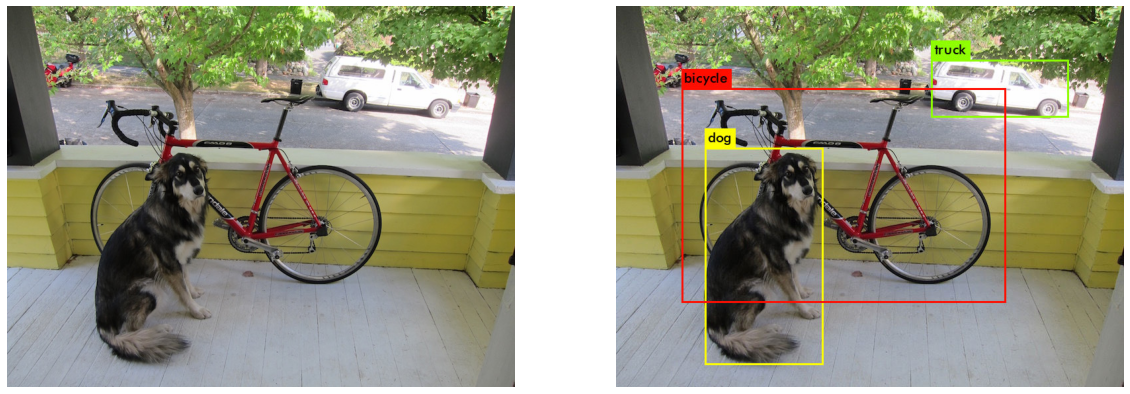

In [ ]:
img_in = cv2.imread('data/dog.jpg')
img_out = cv2.imread('predictions.jpg')
plt.figure(figsize=[20,10])
plt.subplot(121);plt.imshow(img_in[:,:,::-1]);plt.axis('off')
plt.subplot(122);plt.imshow(img_out[:,:,::-1]);plt.axis('off')

darknet/data

In [ ]:
#サンプル画像の一覧
!ls data/*jpg

data/dog.jpg	data/giraffe.jpg  data/kite.jpg    data/scream.jpg
data/eagle.jpg	data/horses.jpg   data/person.jpg


###おまけ

YOLOv5を使って(上のはv3)、手持ちの画像でやってみると...



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/SotaYoshida/yolov5
%cd yolov5
!pip install -qr requirements.txt  # install dependencies (ignore errors)

import torch 
from IPython.display import Image, clear_output  # to display images
from utils.google_utils import gdrive_download  # to download models/datasets
clear_output()
#print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

In [ ]:
!python detect.py --weights yolov5x.pt  --source /content/drive/MyDrive/AdDS2021/pixel_test.jpg 

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=False, img_size=640, iou_thres=0.45, name='exp', project='runs/detect', save_conf=False, save_txt=False, source='/content/drive/MyDrive/AdDS2021/pixel_test.jpg', update=False, view_img=False, weights=['yolov5x.pt'])
YOLOv5 v4.0-67-g5c615db torch 1.7.0+cu101 CPU

Fusing layers... 
Model Summary: 476 layers, 87730285 parameters, 0 gradients, 218.8 GFLOPS
image 1/1 /content/drive/MyDrive/AdDS2021/pixel_test.jpg: 480x640 1 sports ball, 1 tv, 1 laptop, 2 mouses, 2 keyboards, 1 book, Done. (3.387s)
Results saved to runs/detect/exp2
Done. (3.889s)


In [ ]:
!cat output.txt



 /content/drive/MyDrive/AdDS2021/pixel_test.jpg => runs/detect/exp
keyboard 0.26
mouse 0.27
mouse 0.75
sports ball 0.84
tv 0.85
book 0.90
keyboard 0.93
laptop 0.93


 /content/drive/MyDrive/AdDS2021/pixel_test.jpg => runs/detect/exp2
keyboard 0.26
mouse 0.27
mouse 0.75
sports ball 0.84
tv 0.85
book 0.90
keyboard 0.93
laptop 0.93


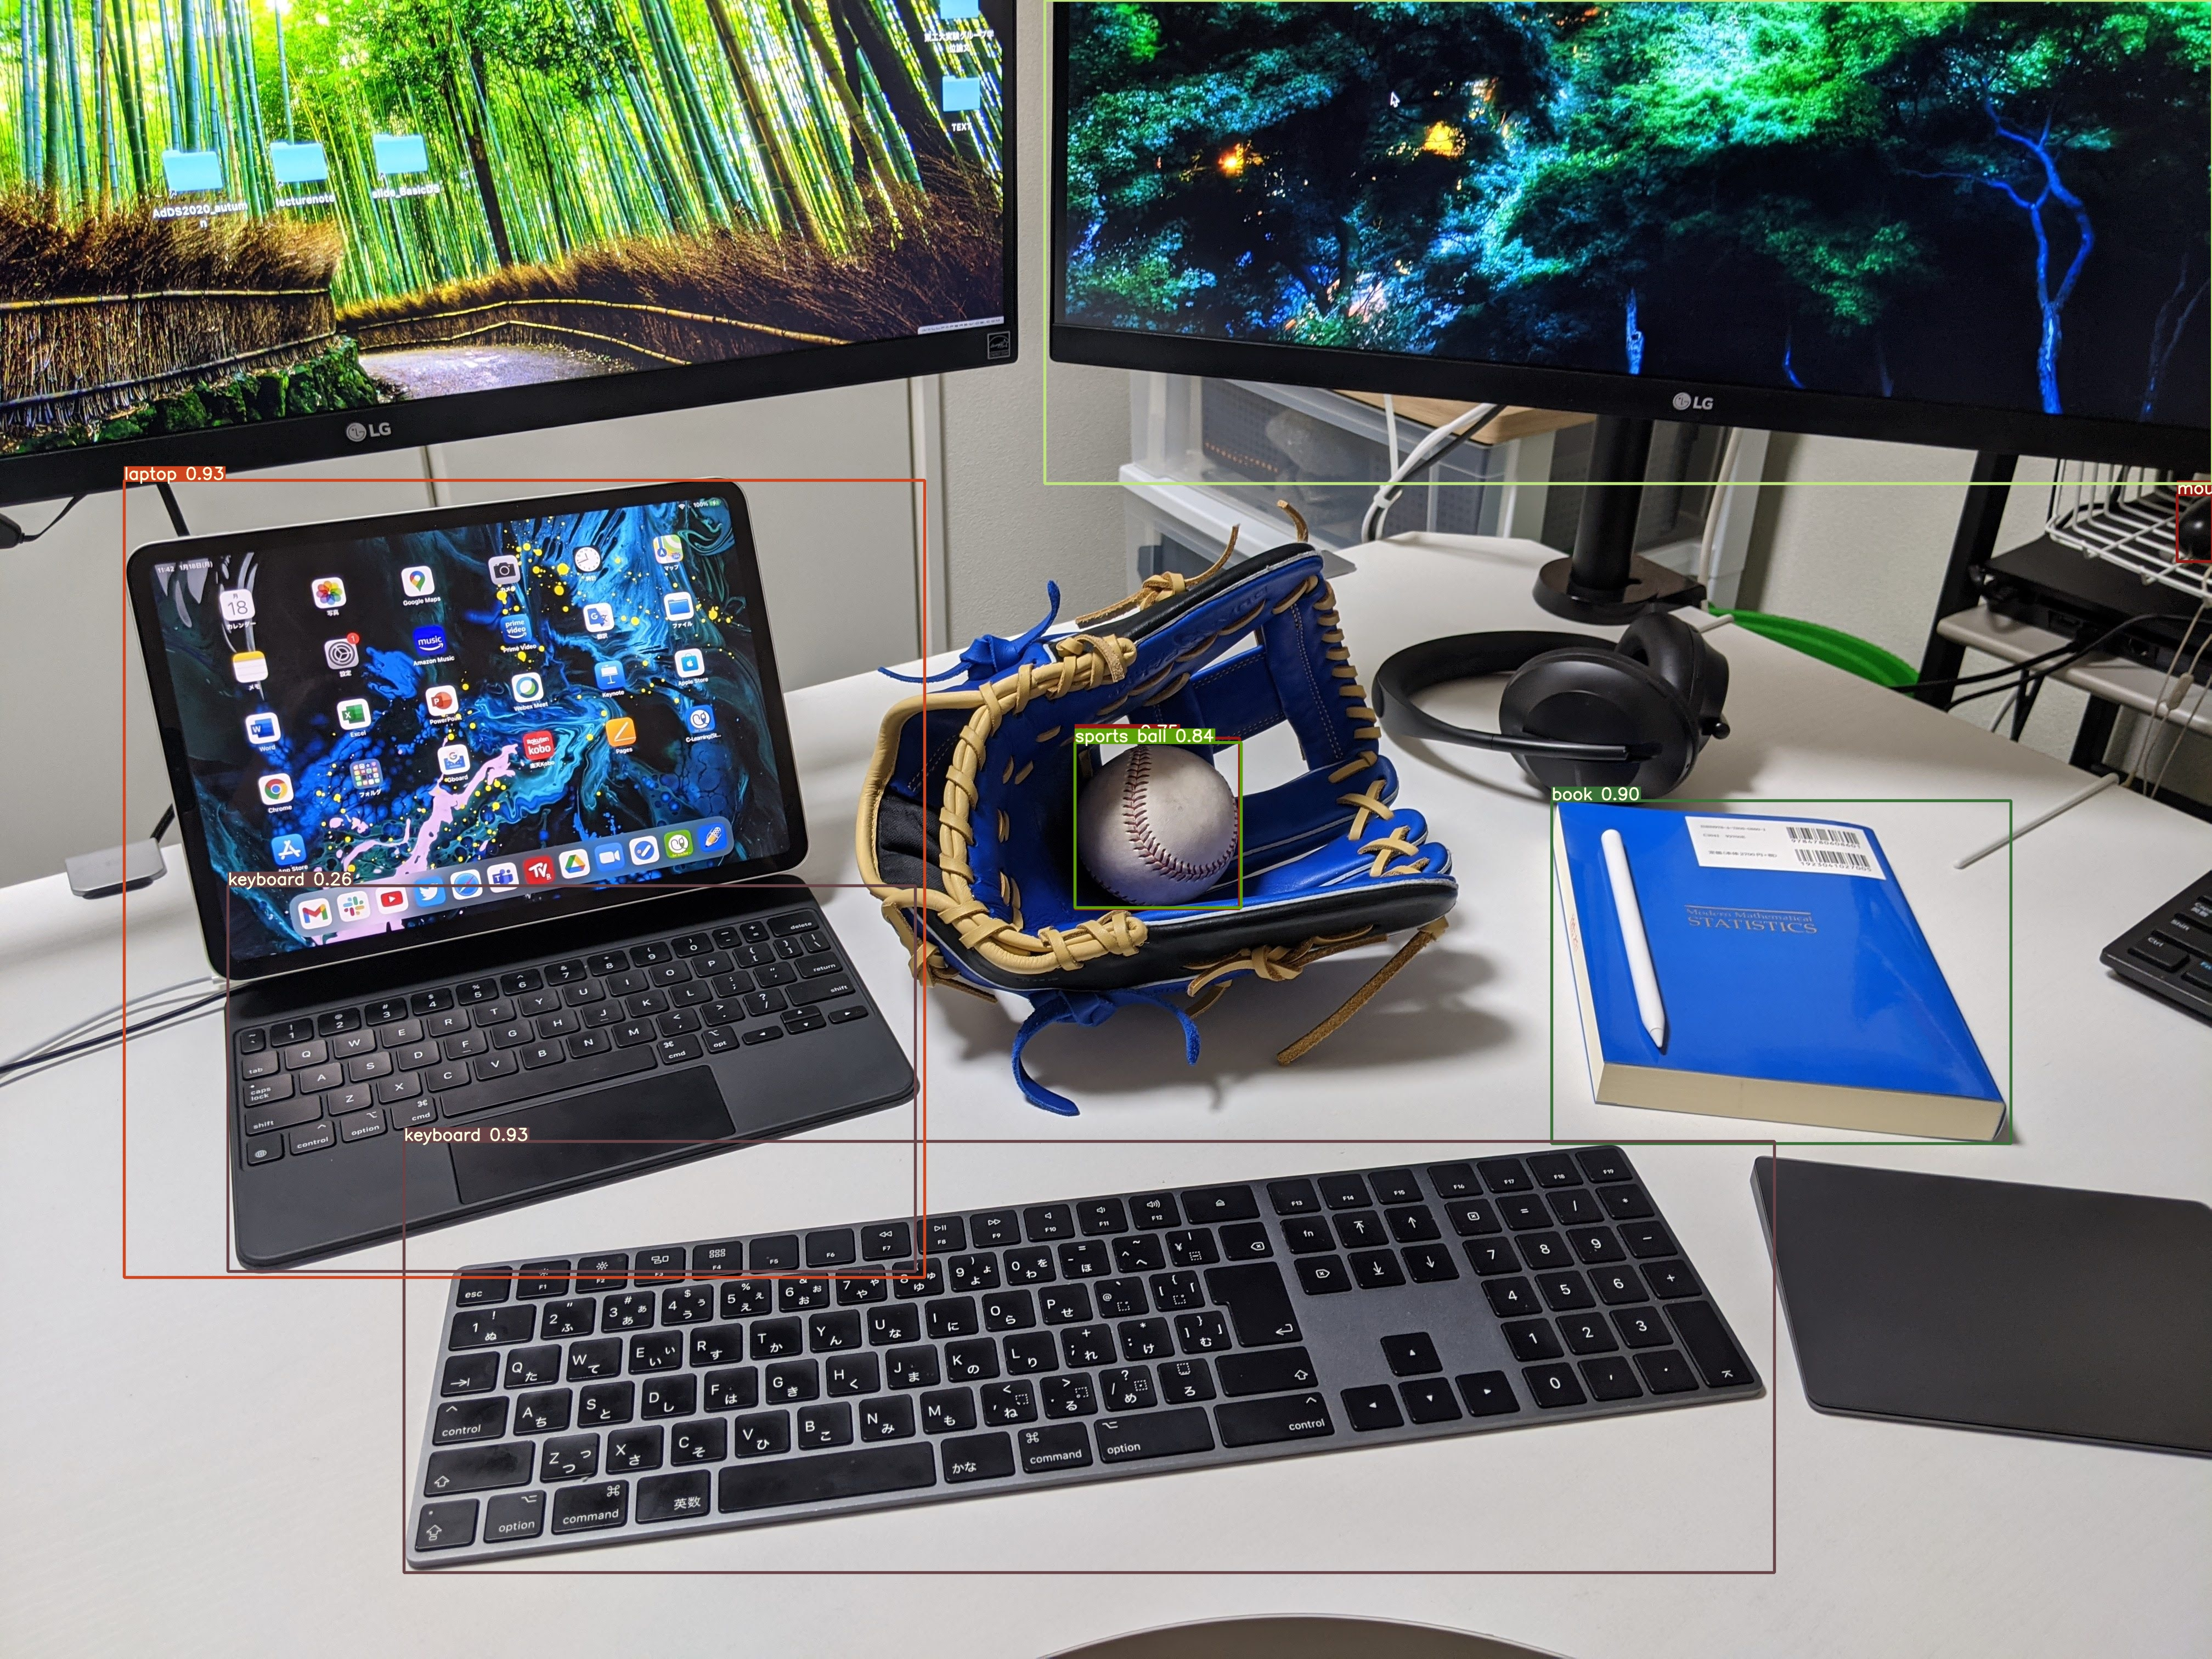

In [ ]:
Image(filename="runs/detect/exp/pixel_test.jpg", width=600) #注) パスは実行の回数や環境に依存する

# LICENSE


Copyright (C) 2021 Sota Yoshida

[ライセンス:クリエイティブ・コモンズ 4.0 表示 (CC-BY 4.0)](https://creativecommons.org/licenses/by/4.0/deed.ja)